(likelihood-ratio-process)=
# Incorrect Models 

## Overview

This  is a sequel to {doc}`this  quantecon lecture <likelihood_bayes>`.  

We discuss  two ways to create compound lottery and their consequences.

A compound lottery can be said to create a _mixture distribution_.

Our two ways of constructing a compound lottery will differ in their **timing**.

* in one, mixing between two possible probability distributions  will occur once and all at the beginning of time

* in the other, mixing between the same two possible possible probability distributions will occur each period

The statistical setting is close but not identical to the problem studied in that quantecon lecture.

In that lecture, there were two  i.i.d. processes that could possibly govern successive draws of a non-negative random variable $W$.

Nature decided  once and for all whether to make  a sequence of IID draws from either $ f $ or from $ g $.

That lecture studied an agent who knew both $f$ and $g$ but  did not know which distribution nature chose at time $-1$.

The agent represented that ignorance  by assuming that nature had chosen  $f$ or $g$ by  flipping an unfair coin that put probability  $\pi_{-1}$ on probability distribution $f$.

That assumption allowed the agent to construct a subjective joint probability distribution over the
random sequence $\{W_t\}_{t=0}^\infty$.  

We studied how the agent would then use the laws of conditional probability and an observed   history $w^t =\{w_s\}_{t=0}^t$   to form   

$$
\pi_t = E [ \textrm{nature chose distribution}  f | w^t] , \quad  t = 0, 1, 2, \ldots
$$

However, in the  setting of this lecture, that rule imputes to the agent an incorrect model.

The reason is that  now the wage sequence is actually described by a different statistical model.

Thus, we change the {doc}`quantecon lecture <likelihood_bayes>` specification in the following way.

Now, **each period** $t \geq 0$, nature flips a possibly unfair coin that comes up $f$ with probability $\alpha$
and $g$ with probability $1 -\alpha$.  

Thus, naturally perpetually draws from the **mixture distribution** with c.d.f. 

$$ 
H(w ) = \alpha F(w) + (1-\alpha) G(w), \quad \alpha \in (0,1)
$$

We'll study two agents  who try to learn about the wage process, but who use different  statistical models.

Both types of agent know $f$ and $g$ but neither knows $\alpha$.

Our first type of agent erroneously thinks that at time $-1$ nature once and for all chose $f$ or $g$ and thereafter
permanently draws from that distribution.

Our second type of agent knows, correctly, that nature mixes $f$ and $g$ with mixing probability $\alpha \in (0,1)$
each period, though the agent doesn't know the mixing parameter.

Our first type of agent applies the learning algorithm described in {doc}`this  quantecon lecture <likelihood_bayes>`>.

In the context of the statistical model that prevailed in that lecture, that was a good learning algorithm and it enabled the Bayesian learner
eventually to learn the distribution that nature had drawn at time $-1$.

This is because the agent's statistical model was *correct* in the sense of being aligned with the data 
generating process.

But in the present context, our type 1 decision maker's model is incorrect because the model $h$ that actually
generates the data is neither $f$ nor $g$ and so is beyond the support of the models that the agent thinks are
possible.

Nevertheless, we'll see that our first type of agent muddles through and eventually learns something  interesting and useful, even though it is not *true*.

Instead, it turn out that our type 1 agent who is armed with a wrong statistical model ends up learning  whichever probability distribution, $f$ or $g$,
is in a special sense *closest* to the $h$ that actually generates the data.

We'll tell the sense in which it is closest.

Our second type of agent understands that nature mixes between $f$ and $g$ each period with a fixed mixing
probability $\alpha$.

But  the agent doesn't know $\alpha$. 

The agent sets out to learn $\alpha$ using Bayes' law applied to his model.

His model is correct in the sense that
it includes the actual data generating process $h$ as a possible distribution.

In this lecture, we'll learn about 

* how nature can *mix* between two distributions $f$ and $g$ to create a new distribution $h$.
   
* The Kullback-Leibler statistical divergence <https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence> that governs statistical learning under an incorrect statistical model

* A useful Python function `numpy.searchsorted` that,  in conjunction with a uniform random number generator, can be used to sample from an arbitrary distribution

As usual, we'll start by importing some Python tools.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import vectorize, njit
from math import gamma
import pandas as pd
import scipy.stats as sp
from scipy.integrate import quad

import seaborn as sns
colors = sns.color_palette()

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
from jax import random

np.random.seed(142857)

@njit
def set_seed():
    np.random.seed(142857)
set_seed()

Let's use Python to generate two beta distributions

In [2]:
# Parameters in the two beta distributions.
F_a, F_b = 1, 1
G_a, G_b = 3, 1.2

@vectorize
def p(x, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x** (a-1) * (1 - x) ** (b-1)

# The two density functions.
f = njit(lambda x: p(x, F_a, F_b))
g = njit(lambda x: p(x, G_a, G_b))

In [3]:
@njit
def simulate(a, b, T=50, N=500):
    '''
    Generate N sets of T observations of the likelihood ratio,
    return as N x T matrix.

    '''

    l_arr = np.empty((N, T))

    for i in range(N):

        for j in range(T):
            w = np.random.beta(a, b)
            l_arr[i, j] = f(w) / g(w)

    return l_arr

We’ll also use the following Python code to prepare some informative simulations

In [4]:
l_arr_g = simulate(G_a, G_b, N=50000)
l_seq_g = np.cumprod(l_arr_g, axis=1)

In [5]:
l_arr_f = simulate(F_a, F_b, N=50000)
l_seq_f = np.cumprod(l_arr_f, axis=1)

## Sampling from  Compound Lottery $H$

We implement two methods  to draw samples from 
our mixture model $\alpha F + (1-\alpha) G$.  

We'll generate samples using each of them and verify that they match well. 

Here is pseudo code for a direct "method 1" for drawing from our compound lottery:

* Step one:

  * use the numpy.random.choice function to flip an unfair coin that selects distribution $F$ with prob $\alpha$
  and $G$ with prob $1 -\alpha$
  
* Step two:
  
  * draw from either $F$ or $G$, as determined by the coin flip.
  
* Step three:

  * put the first two steps in a big loop and do them for each realization of $w$


Our second method uses a uniform distribution and the following fact that we also described and used in the quantecon lecture <https://python.quantecon.org/prob_matrix.html>:

 * If a random variable $X$ has c.d.f. $F(X)$, then a random variable $F^{-1}(U)$ also has c.d.f. $F(x)$, where $U$ is a uniform random variable on $[0,1]$.

In other words, if $X \sim F(x)$ we can generate a random sample from $F$ by drawing a random sample from
a uniform distribution on $[0,1]$ and computing $F^{-1}(U)$.


We'll  use this  fact 
in conjunction with the `numpy.searchsorted` command to sample from $H$ directly.

See <https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html> for the
`searchsorted` function.

See the [Mr. P Solver video on Monte Carlo simulation](https://www.google.com/search?q=Mr.+P+Solver+video+on+Monte+Carlo+simulation&oq=Mr.+P+Solver+video+on+Monte+Carlo+simulation) to see other applications of this powerful trick. 

In the Python code below, we'll use both of our methods and confirm that each of them does a good job of sampling
from our target mixture distribution.

In [6]:
@njit
def draw_lottery(p, N):
    "Draw from the compound lottery directly."

    draws = []
    for i in range(0, N):
        if np.random.rand()<=p:
            draws.append(np.random.beta(F_a, F_b))
        else:
            draws.append(np.random.beta(G_a, G_b))

    return np.array(draws)

def draw_lottery_MC(p, N):
    "Draw from the compound lottery using the Monte Carlo trick."

    xs = np.linspace(1e-8,1-(1e-8),10000)
    CDF = p*sp.beta.cdf(xs, F_a, F_b) + (1-p)*sp.beta.cdf(xs, G_a, G_b)

    Us = np.random.rand(N)
    draws = xs[np.searchsorted(CDF[:-1], Us)]
    return draws

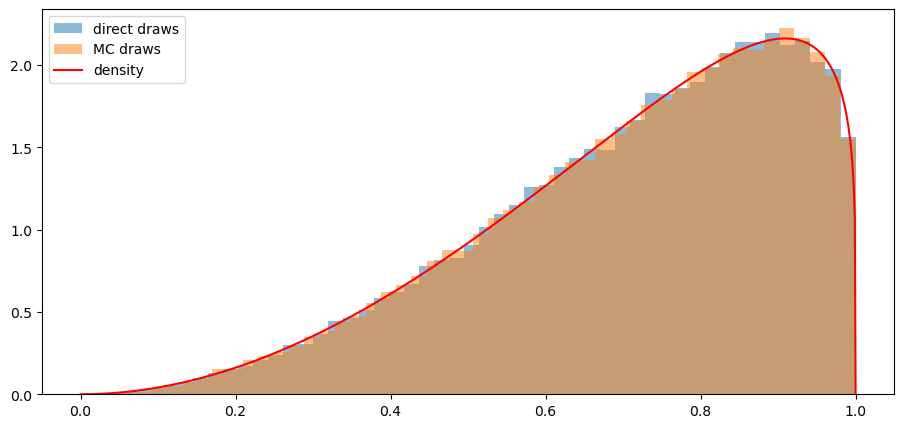

In [7]:
# verify
N = 100000
α = 0.0

sample1 = draw_lottery(α, N)
sample2 = draw_lottery_MC(α, N)

# plot draws and density function
plt.hist(sample1, 50, density=True, alpha=0.5, label='direct draws')
plt.hist(sample2, 50, density=True, alpha=0.5, label='MC draws')

xs = np.linspace(0,1,1000)
plt.plot(xs, α*f(xs)+(1-α)*g(xs), color='red', label='density')

plt.legend()
plt.show()

In [8]:
# %%timeit    # compare speed
# sample1 = draw_lottery(α, N=int(1e6))

In [9]:
# %%timeit
# sample2 = draw_lottery_MC(α, N=int(1e6))

**Note:** With numba acceleration the first method is actually only slightly slower than the second when we generated 1,000,000 samples.

## Type 1 Agent 

We'll now study what our type 1 agent learns

Remember that our type 1 agent uses the wrong statistical model, thinking that nature mixed between $f$ and $g$ once and for all at time $-1$.

The type 1 agent thus uses the learning algorithm studied in {doc}`this  quantecon lecture <likelihood_bayes>`.

We'll briefly review that learning algorithm now.

Let $ \pi_t $ be a Bayesian posterior defined as

$$
\pi_t = {\rm Prob}(q=f|w^t)
$$

The likelihood ratio process plays a principal role  in the formula that governs the evolution
of the posterior probability $ \pi_t $, an instance of **Bayes’ Law**.

Bayes’ law implies that $ \{\pi_t\} $ obeys the recursion

$$
\pi_t=\frac{\pi_{t-1} l_t(w_t)}{\pi_{t-1} l_t(w_t)+1-\pi_{t-1}}
$$ (equation-eq-recur1)

with $ \pi_{0} $ being a Bayesian prior probability that $ q = f $,
i.e., a personal or subjective belief about $ q $ based on our having seen no data.

Below we define a Python function that updates belief $ \pi $ using
likelihood ratio $ \ell $ according to  recursion {eq}`equation-eq-recur1`

In [10]:
@njit
def update(π, l):
    "Update π using likelihood l"

    # Update belief
    π = π * l / (π * l + 1 - π)

    return π

Formula {eq}`equation-eq-recur1` can be generalized  by iterating on it and thereby deriving an
expression for  the time $ t $ posterior $ \pi_{t+1} $ as a function
of the time $ 0 $ prior $ \pi_0 $ and the likelihood ratio process
$ L(w^{t+1}) $ at time $ t $.

To begin, notice that the updating rule

$$
\pi_{t+1}
=\frac{\pi_{t}\ell \left(w_{t+1}\right)}
{\pi_{t}\ell \left(w_{t+1}\right)+\left(1-\pi_{t}\right)}
$$

implies

$$
\begin{aligned}
\frac{1}{\pi_{t+1}}
    &=\frac{\pi_{t}\ell \left(w_{t+1}\right)
        +\left(1-\pi_{t}\right)}{\pi_{t}\ell \left(w_{t+1}\right)} \\
    &=1-\frac{1}{\ell \left(w_{t+1}\right)}
        +\frac{1}{\ell \left(w_{t+1}\right)}\frac{1}{\pi_{t}}.
\end{aligned}
$$

$$
\Rightarrow
\frac{1}{\pi_{t+1}}-1
=\frac{1}{\ell \left(w_{t+1}\right)}\left(\frac{1}{\pi_{t}}-1\right).
$$

Therefore

$$
\begin{aligned}
    \frac{1}{\pi_{t+1}}-1
    =\frac{1}{\prod_{i=1}^{t+1}\ell \left(w_{i}\right)}
        \left(\frac{1}{\pi_{0}}-1\right)
    =\frac{1}{L\left(w^{t+1}\right)}\left(\frac{1}{\pi_{0}}-1\right).
\end{aligned}
$$

Since $ \pi_{0}\in\left(0,1\right) $ and
$ L\left(w^{t+1}\right)>0 $, we can verify that
$ \pi_{t+1}\in\left(0,1\right) $.

After rearranging the preceding equation, we can express $ \pi_{t+1} $ as a
function of  $ L\left(w^{t+1}\right) $, the  likelihood ratio process at $ t+1 $,
and the initial prior $ \pi_{0} $

$$
\pi_{t+1}=\frac{\pi_{0}L\left(w^{t+1}\right)}{\pi_{0}L\left(w^{t+1}\right)+1-\pi_{0}}.
$$ (equation-eq-bayeslaw103)

Formula {eq}`equation-eq-bayeslaw103` generalizes formula {eq}`equation-eq-recur1`.

Formula {eq}`equation-eq-bayeslaw103`  can be regarded as a one step  revision of prior probability $ \pi_0 $ after seeing
the batch of data $ \left\{ w_{i}\right\} _{i=1}^{t+1} $.

## What a type 1 Agent Learns when Mixture $H$ Generates Data

We now study what happens when the mixture distribution $h;\alpha$  truly generated the data each period.   

A submartingale or supermartingale continues to describe $\pi_t$

It raises its ugly head and causes $\pi_t$ to converge either to $0$ or to $1$.

This is true even though in truth nature always mixes between $f$ and $g$.

After verifying that claim about possible limit points of $\pi_t$ sequences, we'll drill down and study
what fundamental force determines the limiting value of $\pi_t$.

Let's set a value of $\alpha$ and then watch how $\pi_t$ evolves.

In [11]:
def simulate_mixed(α, T=50, N=500):
    """
    Generate N sets of T observations of the likelihood ratio,
    return as N x T matrix, when the true density is mixed h;α
    """

    w_s = draw_lottery(α, N*T).reshape(N, T)
    l_arr = f(w_s) / g(w_s)

    return l_arr

def plot_π_seq(α, π1=0.2, π2=0.8, T=200):
    """
    Compute and plot π_seq and the log likelihood ratio process 
    when the mixed distribution governs the data.
    """

    l_arr_mixed = simulate_mixed(α, T=T, N=50)
    l_seq_mixed = np.cumprod(l_arr_mixed, axis=1)
    
    T = l_arr_mixed.shape[1]
    π_seq_mixed = np.empty((2, T+1))
    π_seq_mixed[:, 0] = π1, π2

    for t in range(T):
        for i in range(2):
            π_seq_mixed[i, t+1] = update(π_seq_mixed[i, t], l_arr_mixed[0, t])
    
    # plot
    fig, ax1 = plt.subplots()
    for i in range(2):
        ax1.plot(range(T+1), π_seq_mixed[i, :], label=f"$\pi_0$={π_seq_mixed[i, 0]}")

    ax1.plot(np.nan, np.nan,  '--', color='b', label='Log likelihood ratio process')
    ax1.set_ylabel("$\pi_t$")
    ax1.set_xlabel("t")
    ax1.legend()
    ax1.set_title("when $\\alpha G + (1-\\alpha)$ F governs data")

    ax2 = ax1.twinx()
    ax2.plot(range(1, T+1), np.log(l_seq_mixed[0, :]), '--', color='b')
    ax2.set_ylabel("$log(L(w^{t}))$")

    plt.show()

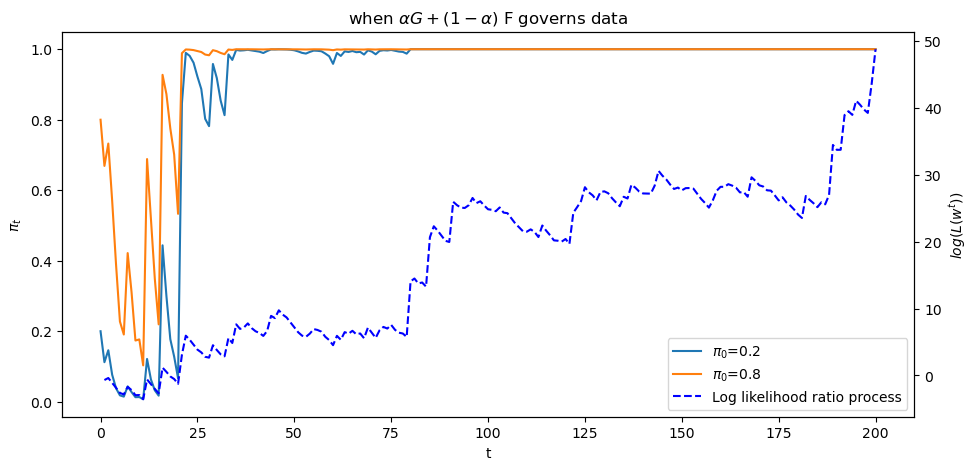

In [12]:
plot_π_seq(α = 0.6)

The above graph shows a sample path of the log likelihood ratio process as the blue dotted line, together with
sample paths of $\pi_t$ that start from two distinct initial conditions.


Let's see what happens when we change $\alpha$

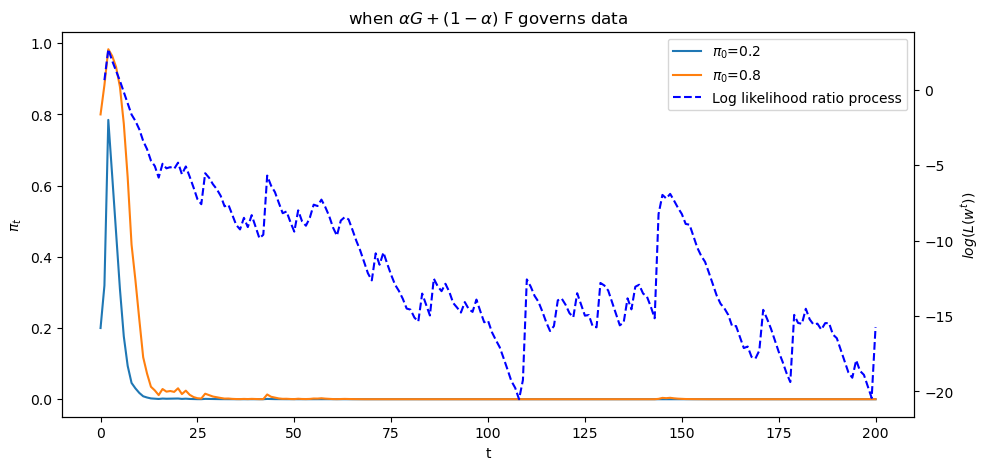

In [13]:
plot_π_seq(α = 0.2)

Evidently, $\alpha$ is having a big effect on the destination of $\pi_t$ as $t \rightarrow + \infty$

## Kullback-Leibler Divergence Governs Limit of $\pi_t$

To understand what determines whether the limit point of  $\pi_t$ is  $0$ or $1$  and how the answer depends on the true value of the mixing probability  $\alpha \in (0,1) $ that generates

$$ h(w) \equiv h(w | \alpha) = \alpha f(w) + (1-\alpha) g(w) $$

we shall compute the following two Kullback-Leibler divergences

$$ 
KL_g (\alpha) = \int \log\left(\frac{g(w)}{h(w)}\right) h(w) d w 
$$

and 

$$ 
KL_f (\alpha) = \int \log\left(\frac{f(w)}{h(w)}\right) h(w) d w 
$$

We shall plot both of these functions against $\alpha$ as we use $\alpha$ to vary
$h(w) = h(w|\alpha)$.

The limit of $\pi_t$ is  determined by 

$$ \min_{f,g} \{KL_g, KL_f\} $$

The only possible limits are $0$ and $1$.

As $\rightarrow +\infty$, $\pi_t$ goes to one if and only if  $KL_f < KL_g$

In [14]:
@vectorize
def KL_g(α):
    "Compute the KL divergence between g and h."
    err = 1e-8                          # to avoid 0 at end points
    ws = np.linspace(err, 1-err, 10000) 
    gs, fs = g(ws), f(ws)
    hs = α*fs + (1-α)*gs
    return np.sum(np.log(gs/hs)*hs)/10000
    
@vectorize
def KL_f(α):
    "Compute the KL divergence between f and h."
    err = 1e-8                          # to avoid 0 at end points
    ws = np.linspace(err, 1-err, 10000)
    gs, fs = g(ws), f(ws)
    hs = α*fs + (1-α)*gs
    return np.sum(np.log(fs/hs)*hs)/10000


# compute KL using quad in Scipy
def KL_g_quad(α):
    "Compute the KL divergence between g and h using scipy.integrate."
    h = lambda x: α*f(x) + (1-α)*g(x)
    return quad(lambda x: np.log(g(x)/h(x))*h(x), 0, 1)[0]

def KL_f_quad(α):
    "Compute the KL divergence between f and h using scipy.integrate."
    h = lambda x: α*f(x) + (1-α)*g(x)
    return quad(lambda x: np.log(f(x)/h(x))*h(x), 0, 1)[0]

# vectorize
KL_g_quad_v = np.vectorize(KL_g_quad)
KL_f_quad_v = np.vectorize(KL_f_quad)


# Let us find the limit point
def π_lim(α, T=5000, π_0=0.4):
    "Find limit of π sequence."
    π_seq = np.zeros(T+1)
    π_seq[0] = π_0
    l_arr = simulate_mixed(α, T, N=1)[0]

    for t in range(T):
        π_seq[t+1] = update(π_seq[t], l_arr[t])
    return π_seq[-1]

π_lim_v = np.vectorize(π_lim)

Let us first plot the KL divergences $KL_g\left(\alpha\right), KL_f\left(\alpha\right)$ for each $\alpha$.

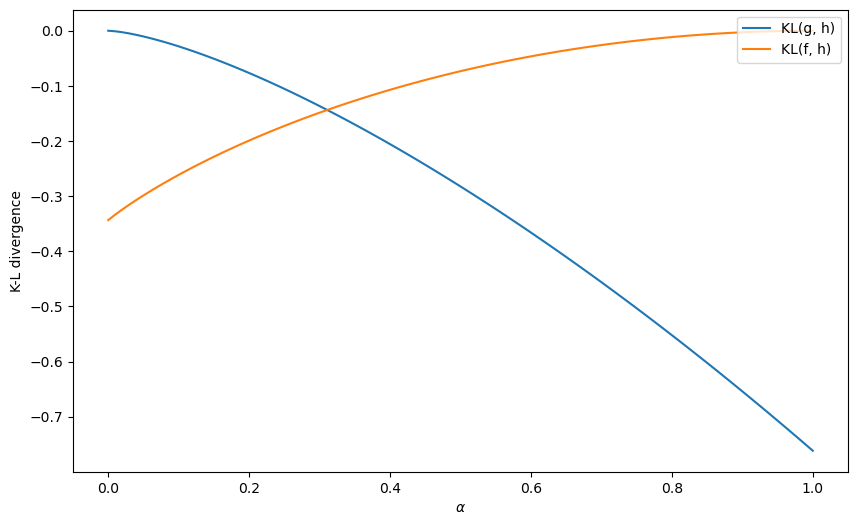

In [15]:
α_arr = np.linspace(0, 1, 100)
KL_g_arr = KL_g(α_arr)
KL_f_arr = KL_f(α_arr)

fig, ax = plt.subplots(1, figsize=[10, 6])

ax.plot(α_arr, KL_g_arr, label='KL(g, h)')
ax.plot(α_arr, KL_f_arr, label='KL(f, h)')
ax.set_ylabel('K-L divergence')
ax.set_xlabel(r'$\alpha$')

ax.legend(loc='upper right')
plt.show()

In [16]:
# # using Scipy to compute KL divergence

# α_arr = np.linspace(0, 1, 100)
# KL_g_arr = KL_g_quad_v(α_arr)
# KL_f_arr = KL_f_quad_v(α_arr)

# fig, ax = plt.subplots(1, figsize=[10, 6])

# ax.plot(α_arr, KL_g_arr, label='KL(g, h)')
# ax.plot(α_arr, KL_f_arr, label='KL(f, h)')
# ax.set_ylabel('K-L divergence')

# ax.legend(loc='upper right')
# plt.show()

Let's compute an $\alpha$ for which  the KL divergence  between $h$ and $g$ is the same as that between $h$ and $f$.

In [17]:
# where KL_f = KL_g
α_arr[np.argmin(np.abs(KL_g_arr-KL_f_arr))]

0.31313131313131315

We can compute and plot the convergence point $\pi_{\infty}$ for each $\alpha$ to verify that the convergence is indeed governed by the KL divergence.

The blue circles show the limiting values of $\pi_t$ that simulations discover for different values of $\alpha$
recorded on the $x$ axis.

Thus, the graph below confirms how a minimum  KL divergence governs what our type 1 agent eventually learns.

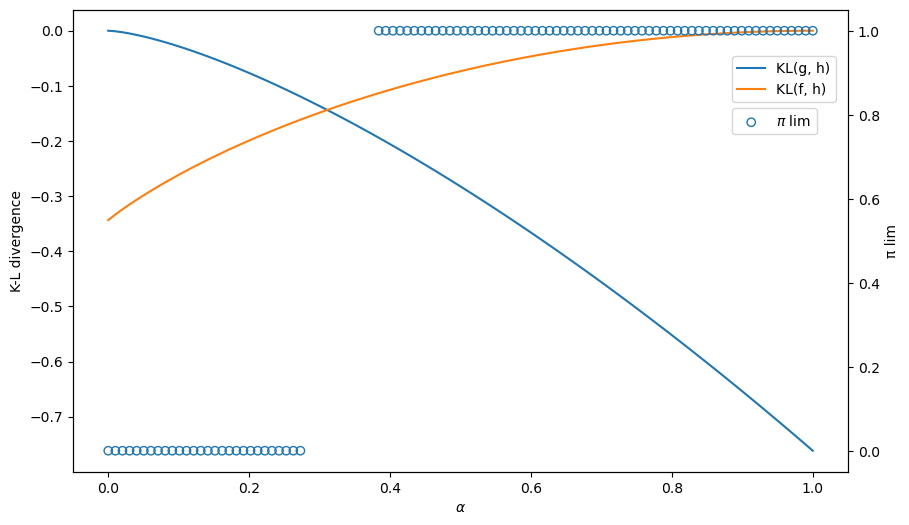

In [18]:
α_arr_x = α_arr[(α_arr<0.28)|(α_arr>0.38)]
π_lim_arr = π_lim_v(α_arr_x)

# plot
fig, ax = plt.subplots(1, figsize=[10, 6])

ax.plot(α_arr, KL_g_arr, label='KL(g, h)')
ax.plot(α_arr, KL_f_arr, label='KL(f, h)')
ax.set_ylabel('K-L divergence')
ax.set_xlabel(r'$\alpha$')

# plot KL
ax2 = ax.twinx()
# plot limit point
ax2.scatter(α_arr_x, π_lim_arr, facecolors='none', edgecolors='tab:blue', label='$\pi$ lim')
ax2.set_ylabel('π lim')

ax.legend(loc=[0.85, 0.8])
ax2.legend(loc=[0.85, 0.73])
plt.show()

Evidently, our type 1 learner who applies Bayes' law to his misspecified set of statistical models eventually learns an approximating model that is as close as possible to the true model, as measured by its
Kullback-Leibler divergence.

## Type 2 Agent

We now describe how our type 2 agent formulates his learning problem and what he eventually learns.

Our type 2 agent understands the correct statistical  model but acknowledges does not know $\alpha$.

We apply Bayes law to deduce an algorithm for  learning $\alpha$ under the assumption
that the agent knows that

$$ 
h(w) = h(w| \alpha)
$$

but does not know $\alpha$.

We'll assume that the person starts out with a prior probabilty $\pi_0(\alpha)$ on
$\alpha \in (0,1)$ where the prior has one of the forms that we deployed in {doc}`this quantecon lecture <bayes_nonconj>`.


We'll fire up `numpyro` and  apply it  to the present situation.

Bayes' law now takes the form


$$ 
\pi_{t+1}(\alpha) = \frac {h(w_{t+1} | \alpha) \pi_t(\alpha)} 
       { \int h(w_{t+1} | \hat \alpha) \pi_t(\hat \alpha) d \hat \alpha } 
$$

We'll use numpyro  to approximate this equation.

We'll create  graphs of the posterior $\pi_t(\alpha)$ as 
$t \rightarrow +\infty$ corresponding to ones presented in the quantecon lecture <https://python.quantecon.org/bayes_nonconj.html>.

We anticipate that a posterior  distribution will collapse around  the true $\alpha$ as 
$t \rightarrow + \infty$.

Let us try a uniform prior first.

We use the `Mixture` class in Numpyro to construct the likelihood function.

In [19]:
α = 0.8

# simulate data with true α
data = draw_lottery(α, 1000)
sizes = [5, 20, 50, 200, 1000, 25000]

def model(w):
    α = numpyro.sample('α', dist.Uniform(low=0.0, high=1.0))

    y_samp = numpyro.sample('w', 
        dist.Mixture(dist.Categorical(jnp.array([α, 1-α])), [dist.Beta(F_a, F_b), dist.Beta(G_a, G_b)]), obs=w)

def MCMC_run(ws):
    "Compute posterior using MCMC with observed ws"
    
    kernal = NUTS(model)
    mcmc = MCMC(kernal, num_samples=5000, num_warmup=1000, progress_bar=False)

    mcmc.run(rng_key=random.PRNGKey(142857), w=jnp.array(ws))
    sample = mcmc.get_samples()
    return sample['α']

The following code generates the graph below that displays Bayesian posteriors for $\alpha$ at various history lengths.

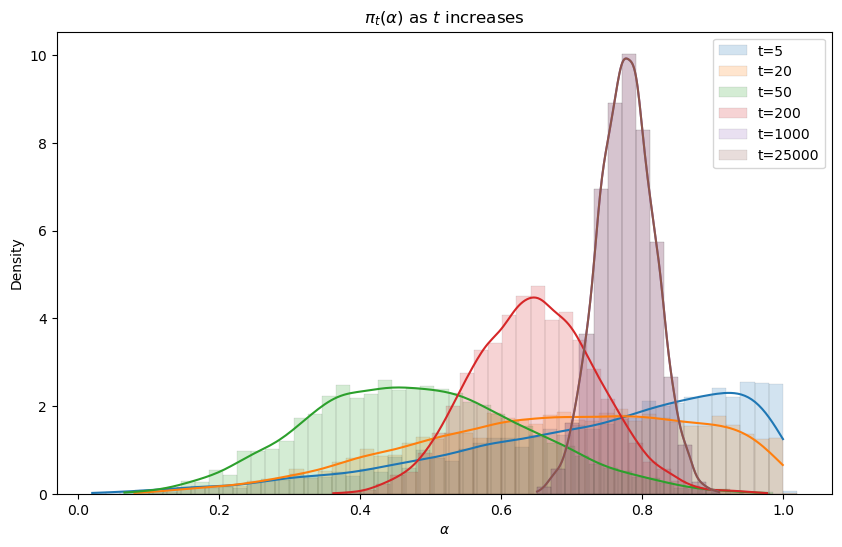

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(sizes)):
    sample = MCMC_run(data[:sizes[i]])
    sns.histplot(
        data=sample, kde=True, stat='density', alpha=0.2, ax=ax, 
        color=colors[i], binwidth=0.02, linewidth=0.05, label=f't={sizes[i]}'
    )
ax.set_title('$\pi_t(\\alpha)$ as $t$ increases')
ax.legend()
ax.set_xlabel('$\\alpha$')
plt.show() 

Evidently,  the Bayesian posterior  narrows in on the true value  $\alpha = .8$ of the mixing parameter as the length of a history of observations grows.  

## Concluding Remarks

Our type 1 person  deploys an incorrect statistical  model.  

He believes
that either $f$ or $g$ generated the $w$ process, but just doesn't know which one.

That is wrong because nature is actually mixing each period with mixing probability $\alpha$.

Our type 1 agent  eventually believes that either $f$ or $g$ generated the $w$ sequence, the outcome being determined by the model, either $f$ or $g$, whose  KL divergence relative to $h$ is smaller.

Our type 2 agent has a different statistical model, one that is correctly specified.  

He knows the parametric form of the statistical model but not the mixing parameter $\alpha$.

He knows that he does not know it.

But by using Bayes' law in conjunction with his statistical model and a history of data,  he eventually acquires a more and more accurate inference about $\alpha$.

This little laboratory  exhibits some important general principles that govern outcomes of Bayesian learning of misspecified models.

Thus, the  following situation prevails quite generally in empirical work.

A scientist approaches the data with a manifold $S$ of statistical models $ s (X | \theta)$ , where $s$ is a probability distribution over a random vector $X$, $\theta \in \Theta$
is a vector of parameters, and $\Theta$ indexes the manifold of models.

The scientist with observations that he interprests as realizations $x$ of the random vector $X$ wants to solve an **inverse problem** of somehow _inverting_
$s(x | \theta)$ to infer $\theta$ from $x$.

But the scientist's model is misspecified, being only an approximation to an unknown  model $h$ that nature uses to generate $X$.

If the scientist uses Bayes' law or a related  likelihood-based  method to infer $\theta$, it occurs quite generally that for large sample sizes the inverse problem infers a  $\theta$ that minimizes  the KL divergence of the scientist's model $s$ relative to nature's   model $h$.